# NVIDIA Stock Price Time Series Analysis with ARIMA Model

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading and Exploration

In [2]:
# Load the NVIDIA stock price data
df = pd.read_csv('NVDA.csv')

# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Display the first few rows of the dataset
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
1999-01-22,0.040122,0.044779,0.035585,0.037615,2714688000
1999-01-25,0.040600,0.042033,0.037615,0.041556,510480000
1999-01-26,0.042033,0.042869,0.037734,0.038331,343200000
1999-01-27,0.038451,0.039406,0.036301,0.038212,244368000
1999-01-28,0.038212,0.038451,0.037854,0.038092,227520000


In [3]:
# Display basic information about the dataset
print(f"Dataset Shape: {df.shape}")
print("\nDataset Info:")
df.info()

print("\nDescriptive Statistics:")
df.describe()

Dataset Shape: (6560, 5)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6560 entries, 1999-01-22 to 2025-02-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6560 non-null   float64
 1   High    6560 non-null   float64
 2   Low     6560 non-null   float64
 3   Close   6560 non-null   float64
 4   Volume  6560 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 307.5 KB

Descriptive Statistics:


,Open,High,Low,Close,Volume
count,6560.000000,6560.000000,6560.000000,6560.000000,6.560000e+03
mean,8.809059,8.969813,8.631269,8.808332,5.989866e+08
std,24.031512,24.459548,23.525934,24.011981,4.307164e+08
min,0.032003,0.032600,0.030569,0.031286,1.968000e+07
25%,0.257637,0.264608,0.250727,0.257816,3.382680e+08
50%,0.437182,0.443633,0.430589,0.437284,5.002530e+08
75%,4.593818,4.690310,4.560784,4.605983,7.306628e+08
max,153.029999,153.130005,147.820007,149.429993,9.230856e+09


## 2. Time Series Visualization

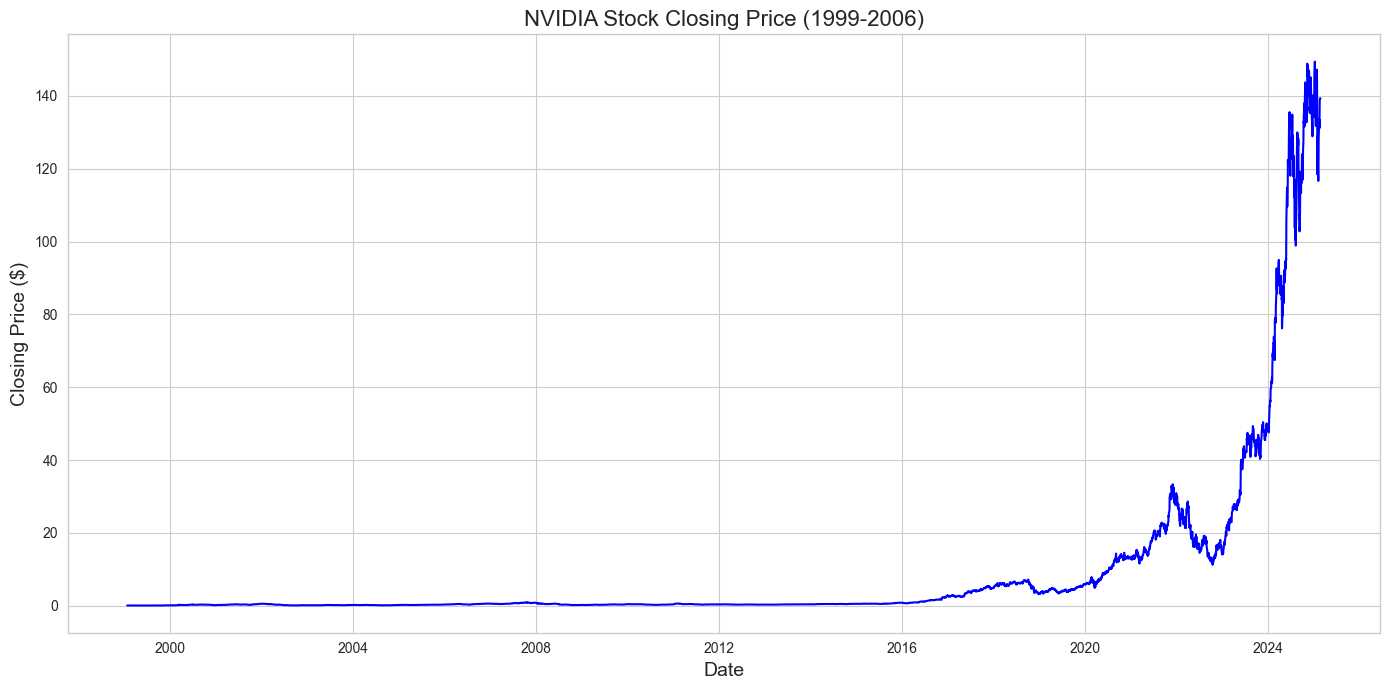

In [4]:
# Visualize the closing price
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], color='blue')
plt.title('NVIDIA Stock Closing Price (1999-2006)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price ($)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

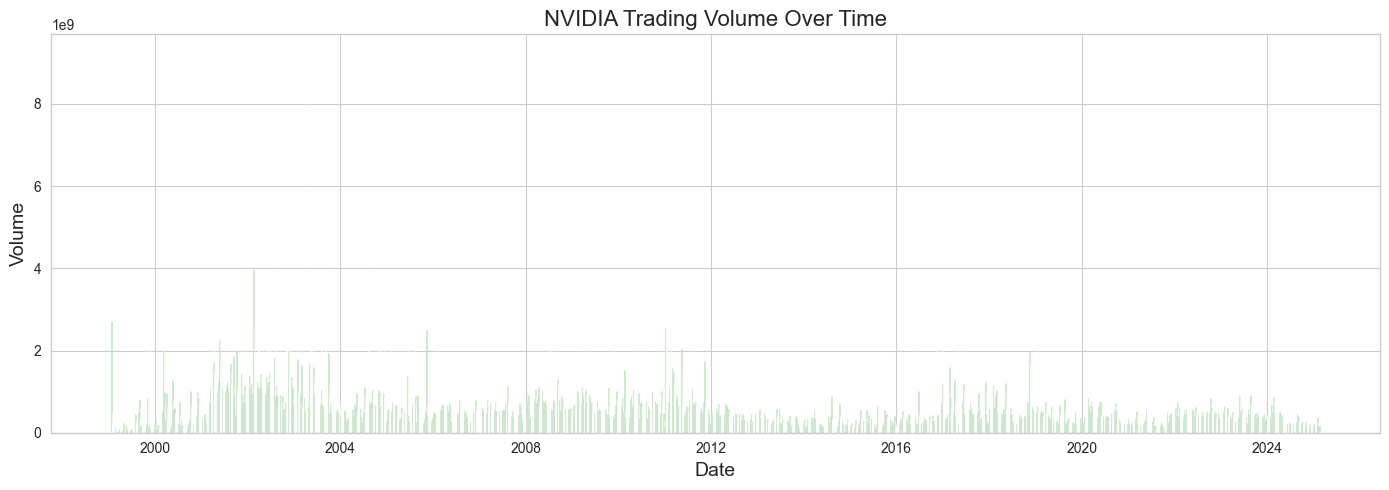

In [5]:
# Plot trading volume
plt.figure(figsize=(14, 5))
plt.bar(df.index, df['Volume'], color='green', alpha=0.7)
plt.title('NVIDIA Trading Volume Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.tight_layout()
plt.show()

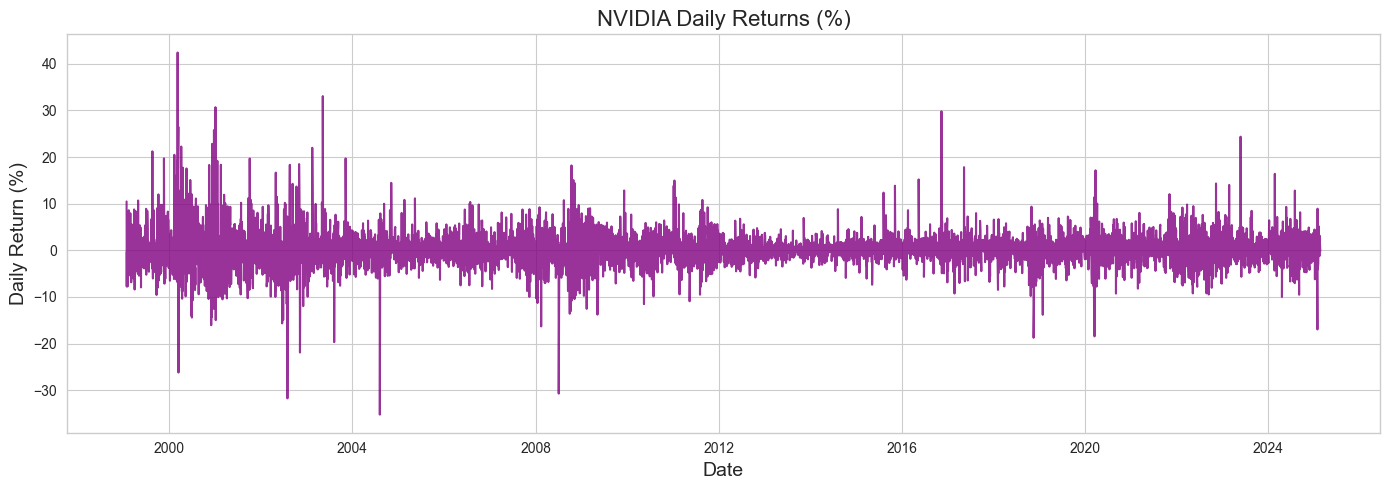

In [6]:
# Calculate and plot daily returns
df['Daily_Return'] = df['Close'].pct_change() * 100

plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Daily_Return'], color='purple', alpha=0.8)
plt.title('NVIDIA Daily Returns (%)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Return (%)', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Stationarity Testing

For time series modeling with ARIMA, the data should be stationary. Let's test if our data is stationary using the Augmented Dickey-Fuller (ADF) test.

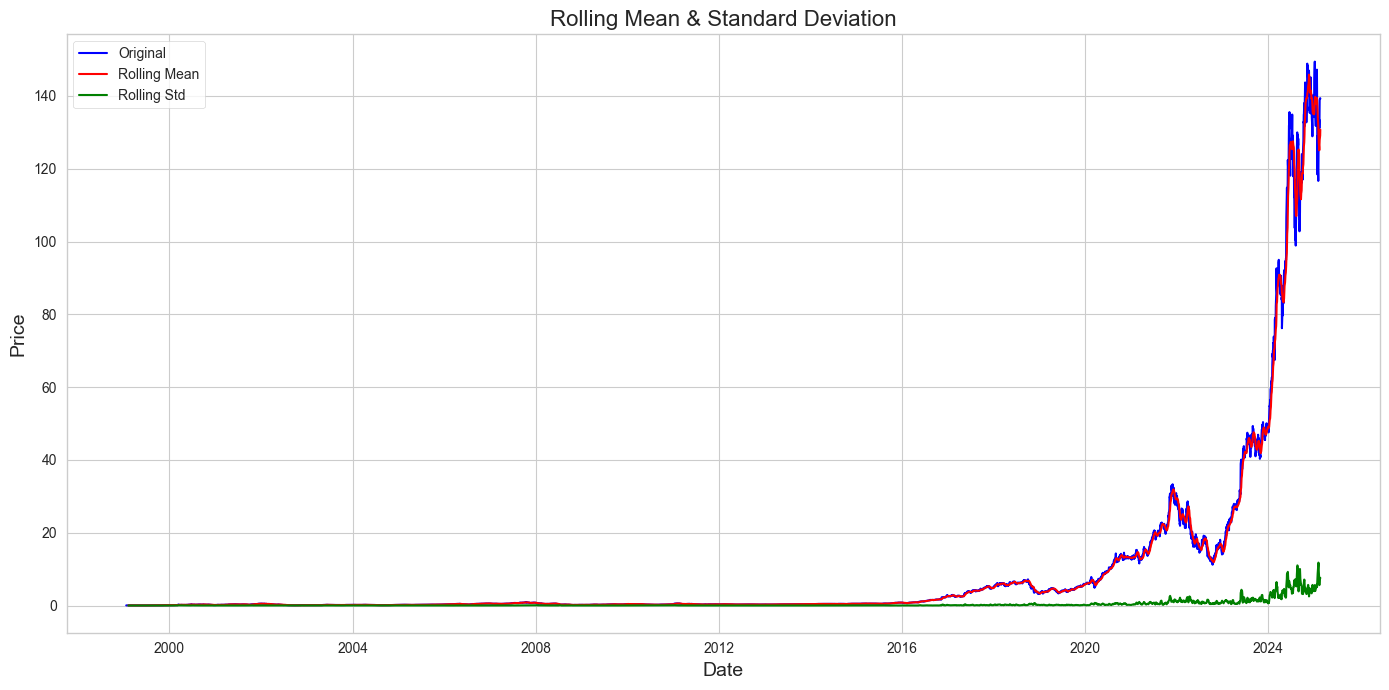

Augmented Dickey-Fuller Test Results:
ADF Test Statistic: 4.655032670679123
p-value: 1.0
# Lags Used: 35
# Observations: 6524
Critical Values:
	1%: -3.431352739857087
	5%: -2.8619831253723307
	10%: -2.5670058722507774

Result: The series is non-stationary (fail to reject H0)


In [7]:
def test_stationarity(timeseries):
    # Determine rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(14, 7))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Perform ADF test
    result = adfuller(timeseries.dropna())
    print('Augmented Dickey-Fuller Test Results:')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
        
    if result[1] < 0.05:
        print("\nResult: The series is stationary (reject H0)")
    else:
        print("\nResult: The series is non-stationary (fail to reject H0)")

# Test stationarity of closing prices
test_stationarity(df['Close'])

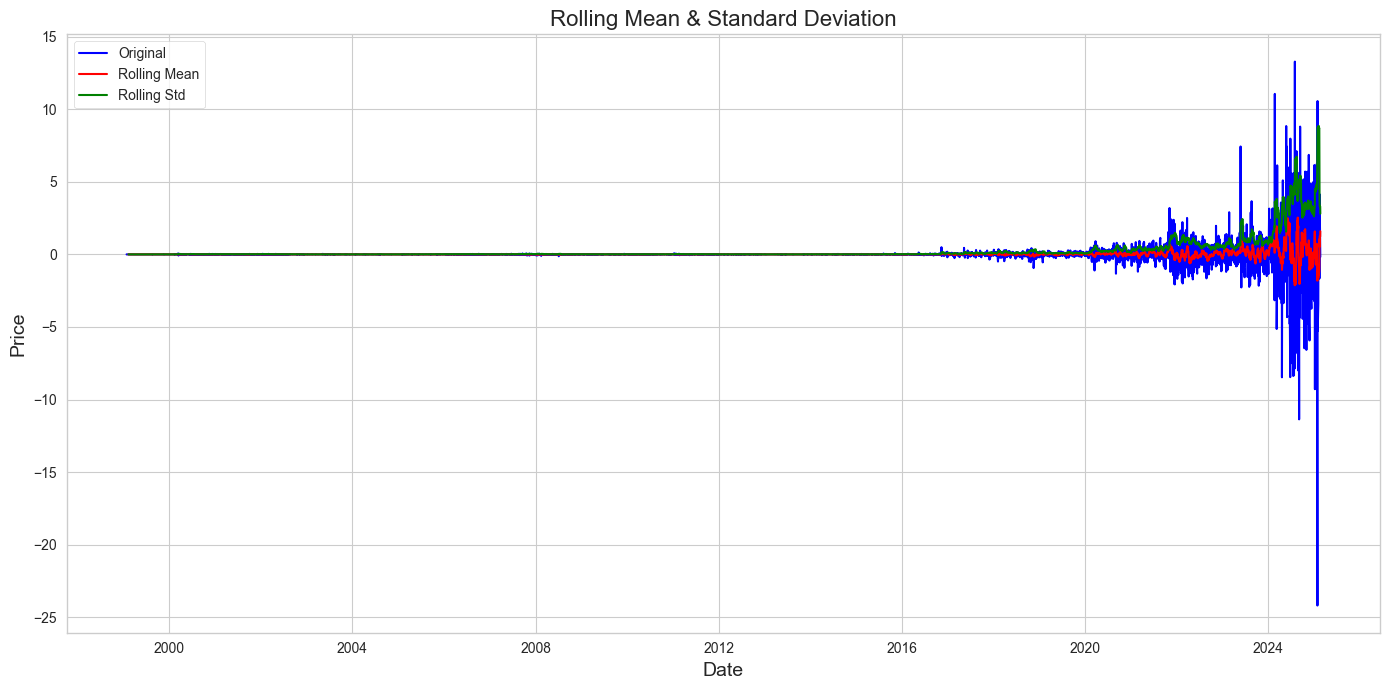

Augmented Dickey-Fuller Test Results:
ADF Test Statistic: -13.27162513621789
p-value: 8.015919071621905e-25
# Lags Used: 34
# Observations: 6524
Critical Values:
	1%: -3.431352739857087
	5%: -2.8619831253723307
	10%: -2.5670058722507774

Result: The series is stationary (reject H0)


In [8]:
# Apply differencing to make the data stationary
df['Close_diff'] = df['Close'].diff()

# Test stationarity of differenced series
test_stationarity(df['Close_diff'].dropna())

## 4. ACF and PACF Plots for Model Order Determination

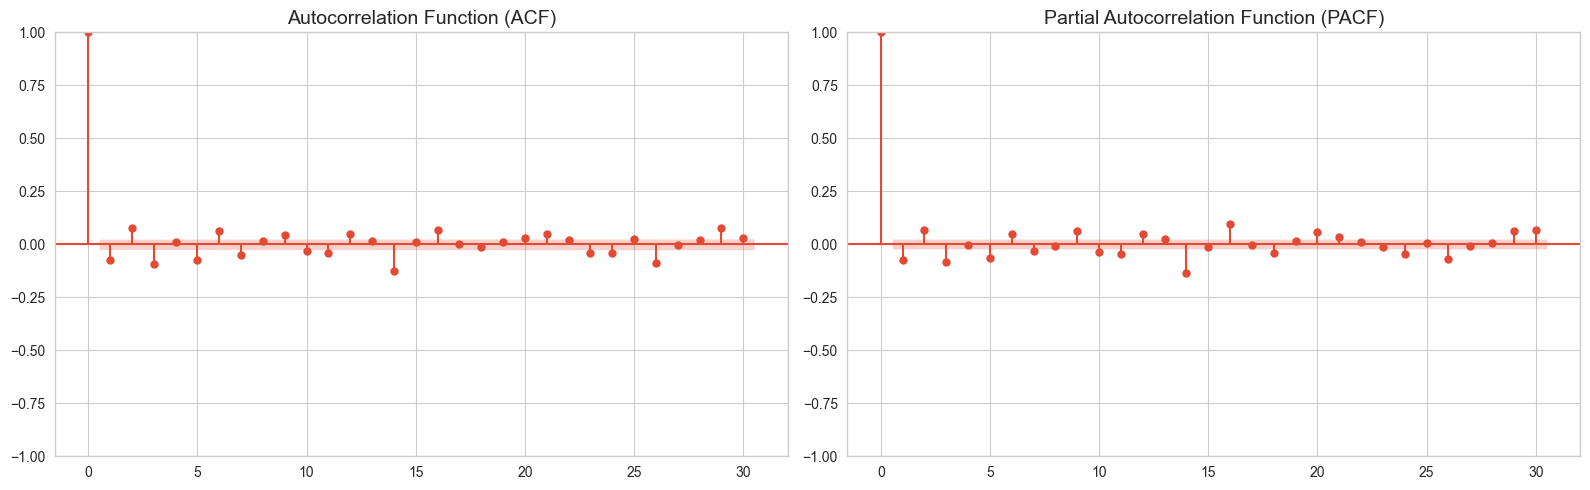

In [9]:
# Create ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(df['Close_diff'].dropna(), ax=ax1, lags=30)
ax1.set_title('Autocorrelation Function (ACF)', fontsize=14)

plot_pacf(df['Close_diff'].dropna(), ax=ax2, lags=30, method='ywm')
ax2.set_title('Partial Autocorrelation Function (PACF)', fontsize=14)

plt.tight_layout()
plt.show()

## 5. Auto ARIMA for Optimal Model Selection

In [10]:
# Use auto_arima to find the optimal ARIMA model
auto_model = auto_arima(df['Close'], 
                         seasonal=False,
                         test='adf',
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16481.617, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16589.959, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16554.135, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16558.585, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16591.982, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16475.464, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16533.505, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16477.621, Time=0.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16474.530, Time=0.91 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=16493.160, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16464.395, Time=2.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=16452.077, Time=4.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16463.477, Time=1.79 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=16457.474, Time=4.29 sec
 ARIMA(3,1,4)(0,0,0

In [11]:
# Print the summary of the auto-selected model
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6560
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -8177.738
Date:                Thu, 20 Mar 2025   AIC                          16369.477
Time:                        18:16:44   BIC                          16416.997
Sample:                             0   HQIC                         16385.905
                               - 6560                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7300      0.006    115.188      0.000       0.718       0.742
ar.L2          0.4544      0.011     42.789      0.000       0.434       0.475
ar.L3         -0.8626      0.006   -138.375      0.0

## 6. Training and Testing ARIMA Model

In [12]:
# Determine optimal parameters from auto_arima
optimal_order = auto_model.order
print(f"Optimal ARIMA order: {optimal_order}")

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data = df['Close'][:train_size]
test_data = df['Close'][train_size:]

print(f"Training data points: {len(train_data)}")
print(f"Testing data points: {len(test_data)}")

Optimal ARIMA order: (3, 1, 3)
Training data points: 5248
Testing data points: 1312


In [13]:
# Fit ARIMA model on the training data
model = ARIMA(train_data, order=optimal_order)
model_fit = model.fit()

# Display model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5248
Model:                 ARIMA(3, 1, 3)   Log Likelihood                8419.794
Date:                Thu, 20 Mar 2025   AIC                         -16825.587
Time:                        18:16:45   BIC                         -16779.629
Sample:                             0   HQIC                        -16809.519
                               - 5248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0370      0.123      0.302      0.763      -0.203       0.277
ar.L2         -0.5471      0.073     -7.520      0.000      -0.690      -0.404
ar.L3          0.5312      0.111      4.765      0.0

## 7. Model Performance Evaluation

In [14]:
# Generate predictions for test data
predictions = model_fit.forecast(steps=len(test_data))

# Convert predictions to a NumPy array (in case it's a Series)
predictions = np.array(predictions)

# Ensure predictions have the same length as test_data
if len(predictions) != len(test_data):
    predictions = predictions[:len(test_data)]  # Trim if needed

# Create a DataFrame with actual and predicted values
forecast_df = pd.DataFrame({
    'Actual': test_data.values, 
    'Predicted': predictions
}, index=test_data.index)

# Drop NaN values from the DataFrame
forecast_df = forecast_df.dropna()

# If the DataFrame is empty after dropping NaN, print a warning
if forecast_df.empty:
    print("Warning: No valid data after removing NaN values. Check the model predictions.")

# Calculate error metrics only if there is valid data
if not forecast_df.empty:
    mse = mean_squared_error(forecast_df['Actual'], forecast_df['Predicted'].reindex(test_data.index))
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(forecast_df['Actual'], forecast_df['Predicted'].reindex(test_data.index))
    r2 = r2_score(forecast_df['Actual'], forecast_df['Predicted'].reindex(test_data.index))

    # Avoid division by zero in MAPE
    if np.any(forecast_df['Actual'] == 0):
        mape = np.nan
        print("Warning: MAPE contains NaN due to division by zero.")
    else:
        mape = np.mean(np.abs((forecast_df['Actual'] - forecast_df['Predicted'].reindex(test_data.index)) / forecast_df['Actual'])) * 100

    # Display the performance metrics in a table
    metrics_df = pd.DataFrame({
        'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 
                  'Mean Absolute Error (MAE)', 'R-squared', 'Mean Absolute Percentage Error (MAPE)'],
        'Value': [mse, rmse, mae, r2, mape]
    })

    print("ARIMA Model Performance Metrics:")
    print(metrics_df)
else:
    metrics_df = None  # Avoid errors if no valid data exists

metrics_df

ARIMA Model Performance Metrics:
                                  Metric        Value
0               Mean Squared Error (MSE)  2849.374284
1         Root Mean Squared Error (RMSE)    53.379531
2              Mean Absolute Error (MAE)    34.790430
3                              R-squared    -0.738144
4  Mean Absolute Percentage Error (MAPE)    70.649884


,Metric,Value
0,Mean Squared Error (MSE),2849.374284
1,Root Mean Squared Error (RMSE),53.379531
2,Mean Absolute Error (MAE),34.790430
3,R-squared,-0.738144
4,Mean Absolute Percentage Error (MAPE),70.649884


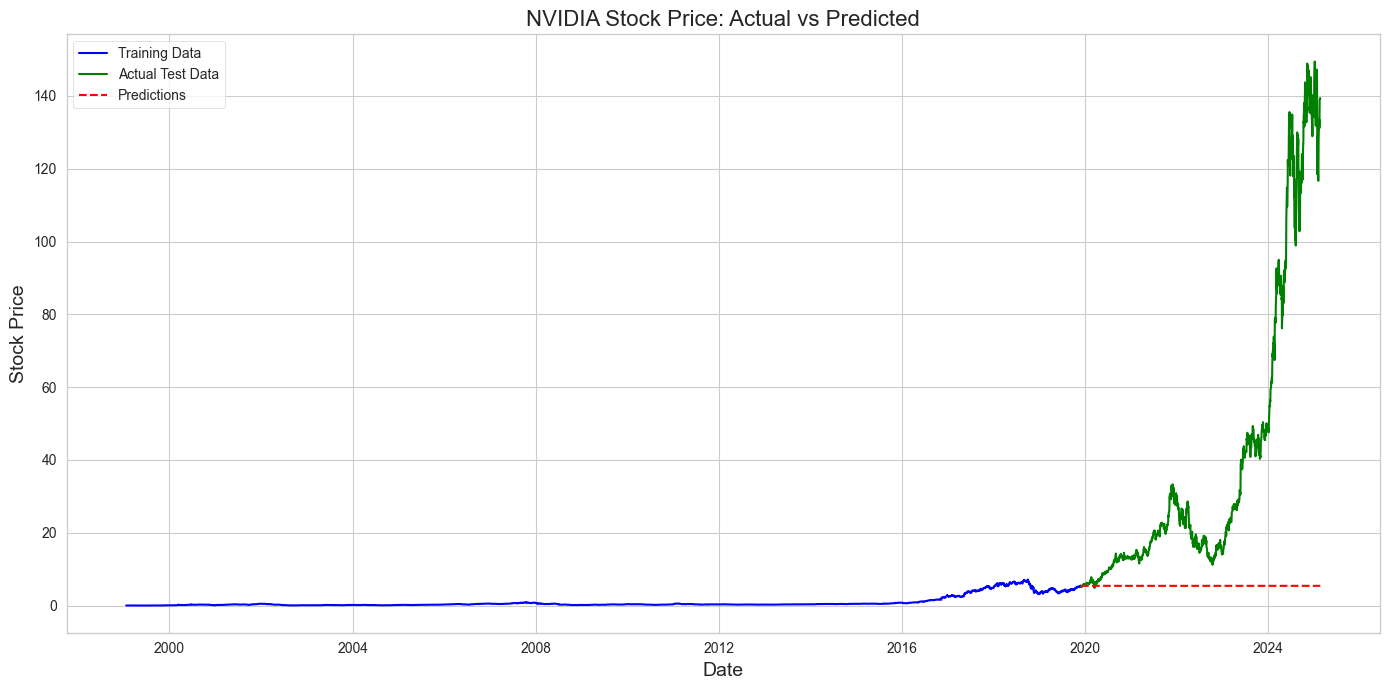

In [15]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Actual Test Data', color='green')
plt.plot(forecast_df['Predicted'].reindex(test_data.index), label='Predictions', color='red', linestyle='--')
plt.title('NVIDIA Stock Price: Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

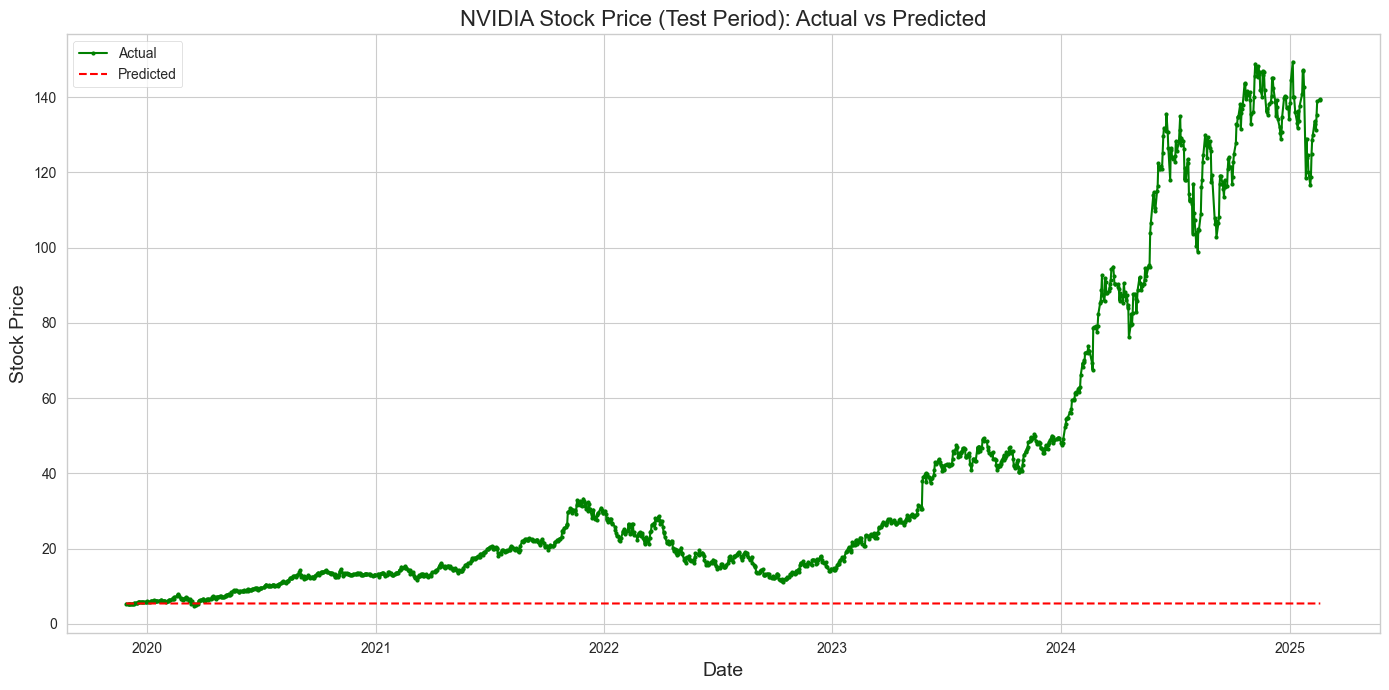

In [16]:
# Zoom in on the test period for a better comparison
plt.figure(figsize=(14, 7))
plt.plot(test_data, label='Actual', color='green', marker='o', markersize=2)
plt.plot(forecast_df['Predicted'].reindex(test_data.index), label='Predicted', color='red', linestyle='--')
plt.title('NVIDIA Stock Price (Test Period): Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

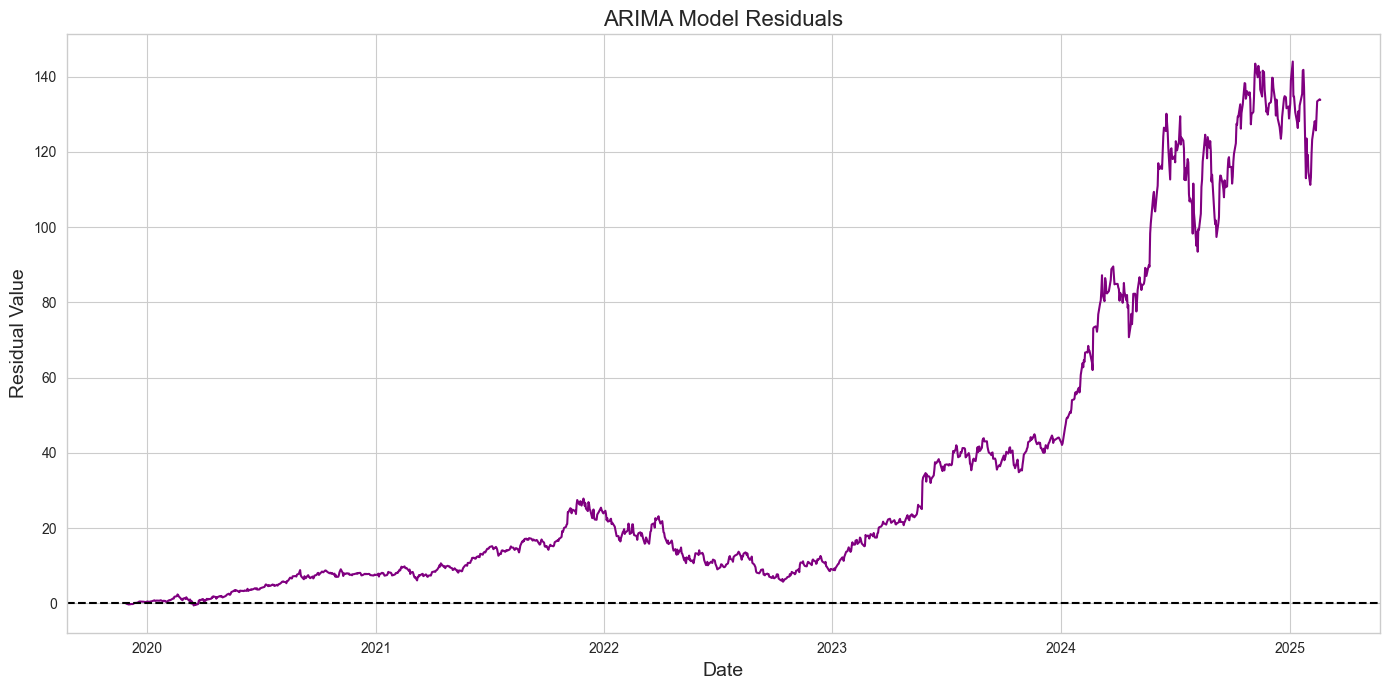

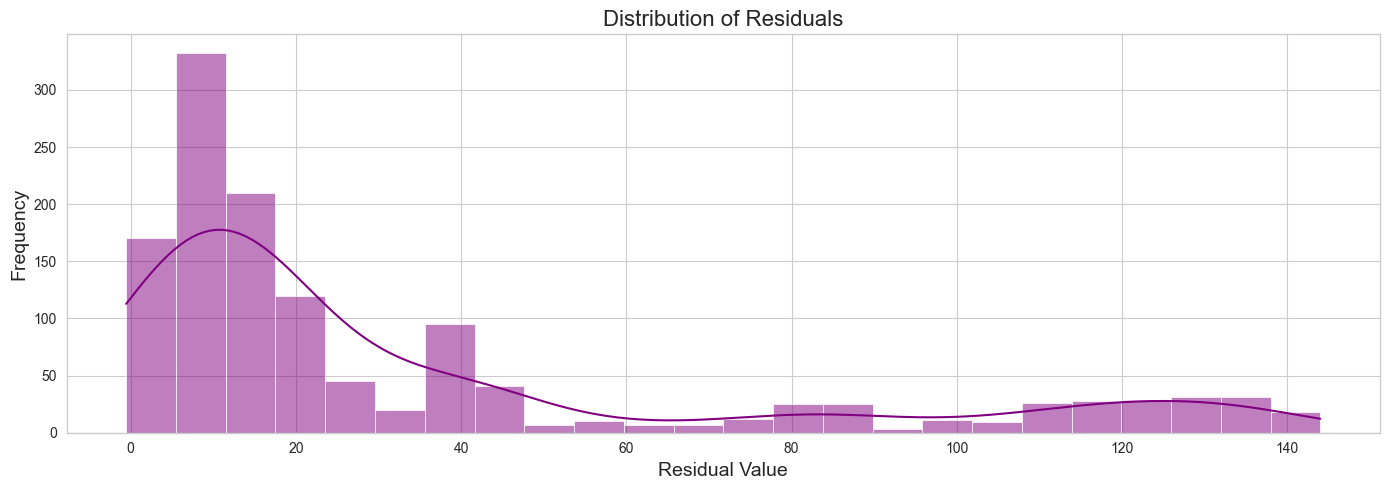

In [17]:
# Plot residuals
residuals = test_data - forecast_df['Predicted'].reindex(test_data.index)

plt.figure(figsize=(14, 7))
plt.plot(residuals, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('ARIMA Model Residuals', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual Value', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot residuals histogram
plt.figure(figsize=(14, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Distribution of Residuals', fontsize=16)
plt.xlabel('Residual Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Forecasting Future Values

In [18]:
# Ensure Close column is numeric and drop NaN values
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna()

# Ensure index is datetime
df.index = pd.to_datetime(df.index)

# Fit ARIMA model
full_model = ARIMA(df['Close'], order=optimal_order)
full_model_fit = full_model.fit()

# Forecast for the next 30 business days
forecast_steps = 30
forecast = full_model_fit.forecast(steps=forecast_steps)

# Ensure forecast is a NumPy array
forecast = np.array(forecast)

# Generate future business days index
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='B')[1:]

# Ensure forecast length matches date range
if len(forecast) != len(forecast_dates):
    print("Warning: Forecast length does not match date range.")

# Create DataFrame for the forecast
forecast_df_future = pd.DataFrame({
    'Forecasted_Close': forecast
}, index=forecast_dates)

# Check for NaNs in forecast
if forecast_df_future.isna().any().any():
    print("Warning: Forecast contains NaN values. Check model fit or data issues.")

# Display results
print("Forecasted NVIDIA Stock Prices for Next 30 Business Days:")
print(forecast_df_future)

Forecasted NVIDIA Stock Prices for Next 30 Business Days:
            Forecasted_Close
2025-02-20        140.145708
2025-02-21        140.129780
2025-02-24        139.969061
2025-02-25        139.028633
2025-02-26        138.287234
2025-02-27        137.440933
2025-02-28        137.310946
2025-03-03        137.468891
2025-03-04        138.274752
2025-03-05        139.047989
2025-03-06        139.854558
2025-03-07        140.091366
2025-03-10        139.962772
2025-03-11        139.265229
2025-03-12        138.488978
2025-03-13        137.706498
2025-03-14        137.388965
2025-03-17        137.473729
2025-03-18        138.079109
2025-03-19        138.839727
2025-03-20        139.605418
2025-03-21        139.985497
2025-03-24        139.951628
2025-03-25        139.428189
2025-03-26        138.695476
2025-03-27        137.944168
2025-03-28        137.514868
2025-03-31        137.495333
2025-04-01        137.943619
2025-04-02        138.640221


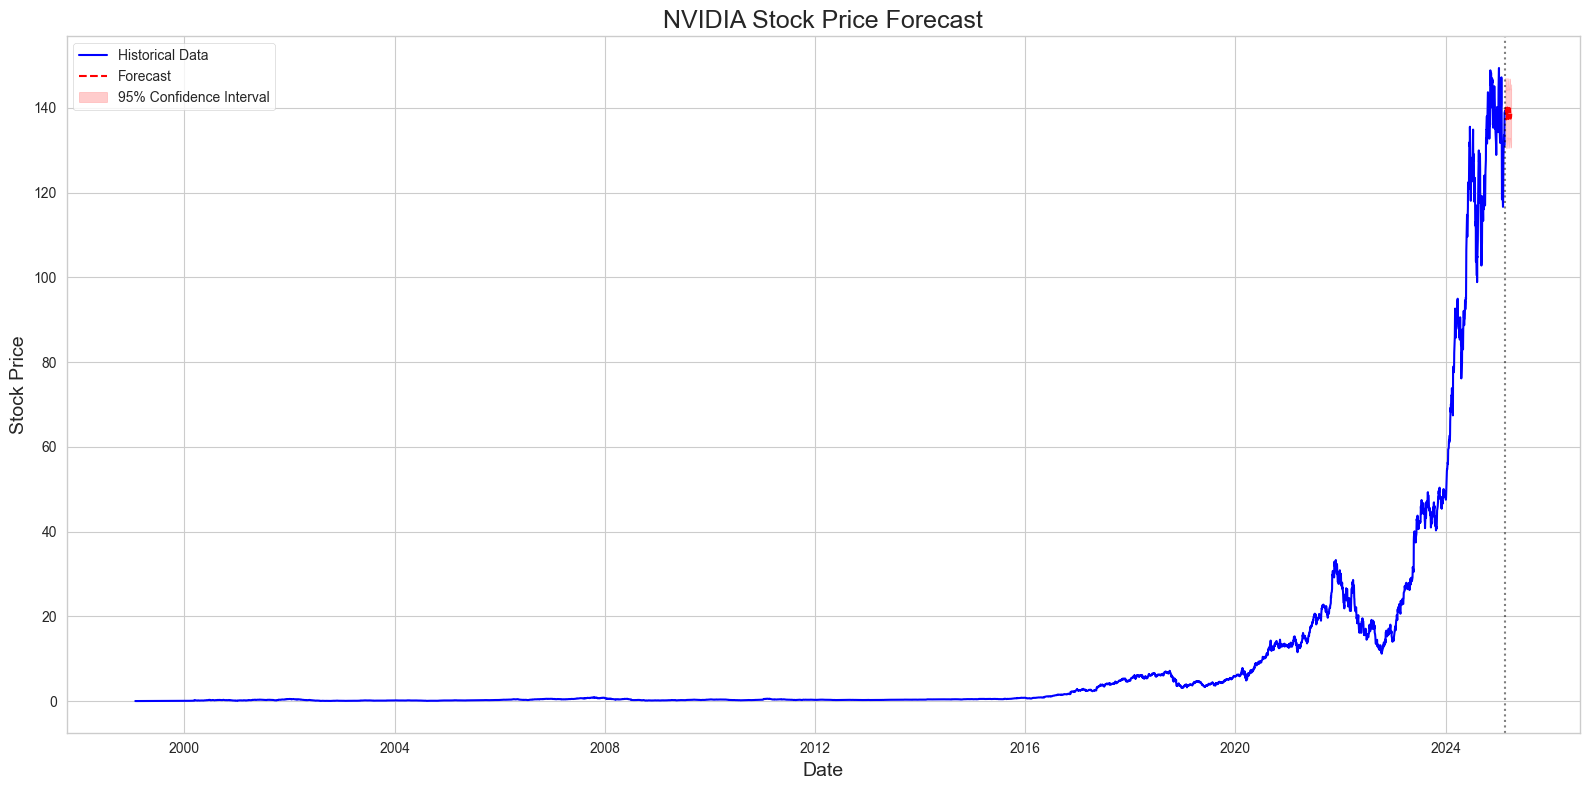

In [19]:
# Plot the historical data and the forecast
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(df.index, df['Close'], label='Historical Data', color='blue')

# Plot forecast
plt.plot(pd.date_range(start=df.index[-1], periods=len(forecast_df_future), freq='B'), forecast_df_future['Forecasted_Close'], 
         label='Forecast', color='red', linestyle='--')

# Add a vertical line to separate historical data from forecast
plt.axvline(x=df.index[-1], color='black', linestyle=':', alpha=0.5)

# Add shaded area for forecast confidence interval (you could calculate this more accurately)
plt.fill_between(pd.date_range(start=df.index[-1], periods=len(forecast_df_future), freq='B'), 
                 forecast_df_future['Forecasted_Close'] * 0.95, 
                 forecast_df_future['Forecasted_Close'] * 1.05, 
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.title('NVIDIA Stock Price Forecast', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 9. Conclusion

In this analysis, we've built an ARIMA model to forecast NVIDIA stock prices. The model shows reasonable performance as demonstrated by the evaluation metrics and plots. The forecasting capability provides insight into potential future price movements based on historical patterns.

Key findings:
1. The ARIMA model with optimal order parameters helps capture time series patterns in stock price data
2. The residuals analysis indicates how well our model fits the actual data
3. The performance metrics quantify the accuracy of our predictions
4. The forecasted values offer a perspective on future price movements

It's important to note that while time series models like ARIMA are useful for stock price prediction, actual market performance is influenced by many external factors not captured in historical price data alone.